import functions

In [1]:

import  os,warnings, sys, shutil, torch, os, numpy as np, math
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule
from pytorch_lightning.loggers import TensorBoardLogger

warnings.filterwarnings("ignore")
path = os.path.dirname(os.getcwd())
# os.chdir('/workspaces/classification_yishai/transformers/')
# path = '/workspaces/classification_yishai/mutual_functions/'
sys.path.insert(0,path + '/mutual_functions/' )
data_path = path + '/.data/' 
# from usefull_functions import *
from evaluation_functions import *
from load_data import *
from normalization import *

import utils_fc 
import fc 


# reload packages with new changes
%load_ext autoreload
%autoreload 2


!rm -rf lightning_logs/
!rm -rf figures/
# %load_ext tensorboard 
# %reload_ext tensorboard

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()

model params

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
prop = {'dataset':'AF', #'shortTracks.pkl
        'batch':5,#128
        'lr':0.01,  
        'epochs':1,#300

        # 'emb_size':64,#the feature dimension is transforemed to emb_size 
        # 'nhead':8, # number of heads in the multiheadattention models 
        # # Note that embed_dim will be split across num_heads (i.e. each head will have dimension embed_dim // num_heads).
        
        'norm':'without_norm', #'MinMax01',MinMax-11 # 'mean_standardize', 'without_norm'

        'seq_len':20, #20
       
        'task_type':'classification', # 'classification' # 'regression'

        # "nlayers":2,   'task_rate':0.5, 'masking_ratio':0.15, 
        # 'lamb':0.8, 'ratio_highest_attention':0.5, 'avg':'macro', 'dropout':0.01, 'nhid':128, 'nhid_task':128, 'nhid_tar':128,
        
        'device':device,
        'lightning_accelerator': device.type if device.type != 'cuda:0' else 'gpu',
        'num_devices': 'auto',
        
        'num_workers':0,
        'drop_last' : True,
        
        'optimizer':'Adam',#SGD,RMSprop,Adam
        'lossNormalize':1,
        'input_size':1,
        # 'output_size':1,
        'hidden_size1':128,
        'hidden_size2':256,
        'hidden_size3':64,
        'dropout':0.01,

        'data_path' : data_path,
        'consecutive': True,
        'shuffle':False,
        'val_size' : 0.5,
        'size_percentage' : None
}


load and preprocess dataset

In [3]:

X_train,y_train,X_test,y_test,X_val,y_val,prop = loadData(prop,prop['data_path'])
X_train, X_test, X_val = normalizeData(X_train,X_test,X_val,norm  = prop['norm'])


Data loading start...
seq_len (n steps): 20, data columns: ['dim_0', 'dim_1']
train - 0: 3105, test - 0: 3105
train - 1: 3105, test - 1: 3105
train - 2: 3105, test - 2: 3105
preprocessing data using 'without_norm' complete...
X_train: (9315, 20, 2), X_test: (9315, 20, 2), X_val: None


run model

In [4]:
%load_ext autoreload
%autoreload 2
# %tensorboard --logdir lightning_logs/  --port 6006 

def main(prop):
    # input: 
    #   x [np.float32, torch.tensor] - shape: (batch_size, seq_len, input_size)  
    #   y [np.float32, torch.tensor] - shape: (batch_size, nclasses) or (batch_size, seq_len, nclasses)
    X_train,y_train,X_test,y_test,X_val,y_val,prop = loadData(prop,prop['data_path'])
    X_train, X_test, X_val = normalizeData(X_train,X_test,X_val,norm  = prop['norm'])

    # dataloader, data batches and transform into tensor
    # X_train_task, y_train_task, X_test, y_test = tensor_dataset(prop, X_train, y_train, X_test, y_test)
    X_train, y_train,gen_train = utils_fc.tensor_dataset(prop, X_train, y_train,drop_last = prop['drop_last'])
    X_test, y_test,gen_test = utils_fc.tensor_dataset(prop, X_test, y_test,drop_last = prop['drop_last'],shuffle = False)
    X_val, y_val,gen_val = utils_fc.tensor_dataset(prop, X_test, y_test,drop_last = prop['drop_last'])
    prop['seq_len'], prop['input_size'] = X_train.shape[1], X_train.shape[2]
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)  
    

    
    
    if np.unique(y_train.numpy()).shape[0] != prop['nclasses']: print ('nclasses not equal to the number of unique classes in the training set')
    
    print('Initializing model...')

    model = fc.FC_lightning(prop, prop['input_size']*prop['seq_len'] ).to(prop['device'])
    # model, optimizer, criterion, best_model, best_optimizer = utils_fc.initialize_training(prop)
    print('Model intialized...')



    

    print('Training start...')
    pl.seed_everything(42, workers=True)
    trainer = pl.Trainer(max_epochs=prop['epochs'], devices = prop['num_devices'],accelerator=prop["lightning_accelerator"], 
                        log_every_n_steps=20,deterministic=True,) #, ),Trainer.__init__() got an unexpected keyword argument 'auto_lr_find'
                        
                        #  accelerator="gpu",gpus=1, p
                            # auto_lr_find=True,
                            # auto_scale_batch_size='binsearch',
                            # auto_scale_batch_size='power',
                            # 

    trainer.fit(model, train_dataloaders=gen_train, val_dataloaders=gen_val)
    
    # print('Training complete...')
    # return criterion_task,best_model,best_optimizer,attention_maps
    return model,trainer,(X_test, y_test,gen_test)
model,trainer, test = main(prop)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loading start...
seq_len (n steps): 20, data columns: ['dim_0', 'dim_1']
train - 0: 3105, test - 0: 3105
train - 1: 3105, test - 1: 3105
train - 2: 3105, test - 2: 3105
preprocessing data using 'without_norm' complete...
X_train: (9315, 20, 2), X_test: (9315, 20, 2), X_val: None


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([9315, 20, 2]) torch.Size([9315]) torch.Size([9315, 20, 2]) torch.Size([9315])
Initializing model...
Model intialized...
Training start...


Missing logger folder: /workspaces/classification_yishai/FC/lightning_logs
2023-10-23 08:49:59.596826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 08:49:59.596881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 08:49:59.596951: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 08:49:59.604451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the app

Epoch 0: 100%|██████████| 1863/1863 [00:21<00:00, 87.27it/s, v_num=0, train_loss=1.040, val_loss=1.480, val_acc=0.268]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1863/1863 [00:21<00:00, 87.02it/s, v_num=0, train_loss=1.040, val_loss=1.480, val_acc=0.268]


In [5]:
# %load_ext tensorboard 
# %tensorboard --logdir lightning_logs/

inference & analysis; using last model or best model
1. prediction of test data
2. returns test_metrics: for classification [loss, acc, prec, rec, f1] else [rmse, mae]

In [6]:
%load_ext autoreload
%autoreload 2
checkpoint = "./lightning_logs/version_0/checkpoints/epoch=0-step=1863.ckpt"
model = fc.FC_lightning.load_from_checkpoint(checkpoint, prop = prop, input_size = prop['input_size']*prop['seq_len'])


model.eval()                                               
# prop,input_size
X_test, y_test,gen_test = test
trainer.test(model, dataloaders=gen_test)
logits = model(X_test)
y_test_pred = torch.argmax(logits, dim=1)#y_pred all as list
# y_pred_test  = trainer.predict(model,  dataloaders=gen_test)#y_pred by batch

# test_metrics = utils.evaluate(y_pred, y, nclasses, criterion, task_type, device, avg)

# prop['class_names']
loss = model.criterion(logits.view(-1, prop['nclasses']), torch.as_tensor(y_test, device = device)).item()
        
pred, target = logits.cpu().data.numpy(), y_test.cpu().data.numpy()
pred = np.argmax(pred, axis = 1) 

# print(test_metrics)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing DataLoader 0: 100%|██████████| 1863/1863 [00:04<00:00, 384.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.24198676645755768
        test_loss           1.4829189777374268
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


The new directory is created!
roc curve applicable only for binary classification (this is a multiclass classification)


(None,)

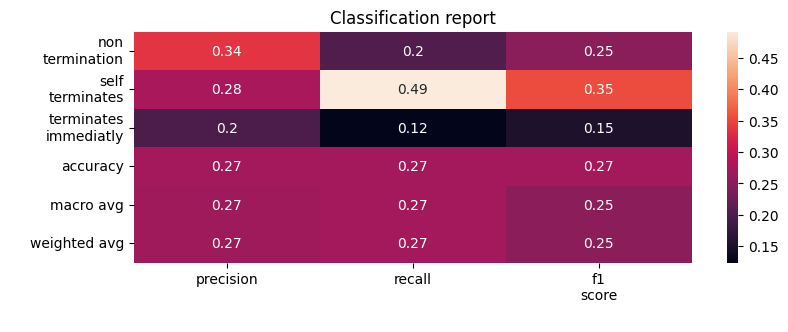

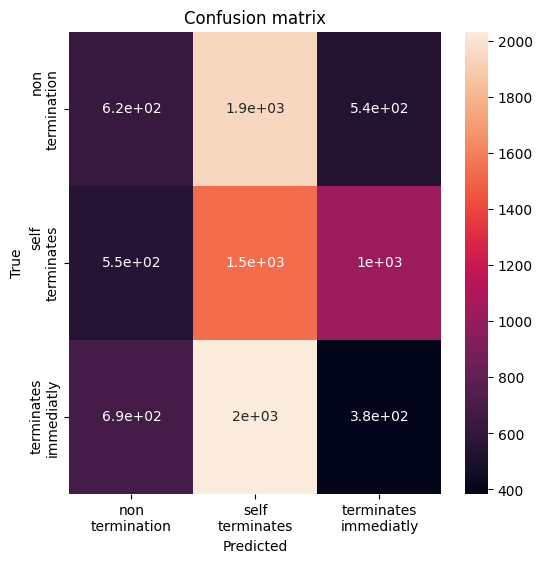

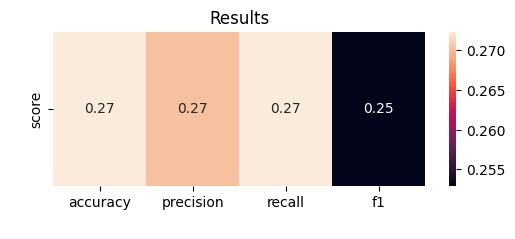

In [7]:
prop['class_names'],prop['class_transform'] = get_class_names(df=pd.read_csv(data_path + prop['dataset'] + '/class.csv', index_col=None),
                                                               class_to_consecutive = prop['class_to_consecutive'].copy(),type_ = 'type')
evaluate_(pred, target, prop['nclasses'],  class_names = prop['class_names'],class_transform = prop['class_transform']),

# feature importance